In [1]:

import tifffile as tf
import zarr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from scipy.spatial import KDTree
import numpy as np
import pandas as pd
import zarr
from scipy.spatial import KDTree
import tifffile as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
import dask.array as da
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.cluster import KMeans




/Users/swarchol/mambaforge/envs/mattress/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [30]:
# cluster_df = pd.read_parquet('/Users/swarchol/Research/bed/data/for_simon_with_umap.parquet')
til_io = tf.TiffFile('/Volumes/Simon/Greg/WD-76845-097.ome.tif',is_ome=True)
til_zarr = zarr.open(til_io.series[0].aszarr())

(40, 27120, 26139)

In [8]:
cluster_df.to_parquet('/Users/swarchol/Research/bed/data/for_simon_with_umap.parquet', index=False)

In [2]:
test = pd.read_csv('/Users/swarchol/Research/bed/data/for_simon_with_umap.csv')
test.head()

,CellID,Hoechst0,Hoechst1,Hoechst2,anti_CD3,anti_CD45RO,Hoechst3,Keratin_570,aSMA_660,Hoechst4,...,Orientation,Sample,Condition,Replicate,emb1,emb2,cluster_2d,UMAP_X,UMAP_Y,kmeans
0,47,15160.563636,46937.436364,42258.036364,0.235838,0.446541,24461.163636,0.270726,0.175902,29225.363636,...,-1.345788,WD-76845-097,CRC,1,8.872235,19.100700,-1,16034.611561,20497.943539,6
1,49,11740.781250,50723.343750,37632.750000,0.227137,0.584889,20075.703125,0.307917,0.174437,23681.062500,...,-1.338040,WD-76845-097,CRC,1,8.379912,20.137026,48,15764.366949,21180.248327,6
2,51,9565.513514,35690.567568,27032.162162,0.200757,0.436587,14392.621622,0.223040,0.162788,16623.810811,...,-1.475095,WD-76845-097,CRC,1,8.799885,19.362713,-1,15994.897394,20670.449801,4
3,52,7308.113636,24641.750000,19214.886364,0.228204,0.662923,9205.522727,0.272994,0.207245,11968.636364,...,-1.390750,WD-76845-097,CRC,1,8.504932,20.219538,48,15832.992590,21234.573253,5
4,53,19249.623188,57667.202899,53509.811594,0.261224,0.704192,30691.275362,0.295741,0.296045,35399.927536,...,-1.441929,WD-76845-097,CRC,1,8.576233,20.350970,48,15872.130942,21321.106528,6


In [3]:
test.columns

Index(['CellID', 'Hoechst0', 'Hoechst1', 'Hoechst2', 'anti_CD3', 'anti_CD45RO',
       'Hoechst3', 'Keratin_570', 'aSMA_660', 'Hoechst4', 'CD4_488', 'CD45_PE',
       'PD1_647', 'Hoechst5', 'CD20_488', 'CD68_555', 'CD8a_660', 'Hoechst6',
       'CD163_488', 'FOXP3_570', 'PDL1_647', 'Hoechst7', 'Ecad_488',
       'Vimentin_555', 'CDX2_647', 'Hoechst8', 'LaminABC_488', 'Desmin_555',
       'CD31_647', 'Hoechst9', 'PCNA_488', 'CollagenIV_647', 'X_centroid',
       'Y_centroid', 'Area', 'MajorAxisLength', 'MinorAxisLength',
       'Eccentricity', 'Solidity', 'Extent', 'Orientation', 'Sample',
       'Condition', 'Replicate', 'emb1', 'emb2', 'cluster_2d', 'UMAP_X',
       'UMAP_Y', 'kmeans'],
      dtype='object')

: 

In [12]:
# find indices of cells with -1 == UMAP_X
neg1 = test[test['UMAP_X'] == -1].index
pos1 = test[test['UMAP_X'] != -1].index

In [26]:
# Fit a linear model mapping emb1 to UMAP_X for the positive cells with an intercept
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error

lm = LinearRegression()
lm.fit(test.loc[pos1, ['emb2']], test.loc[pos1, 'UMAP_X'])

preds = lm.predict(test.loc[pos1, ['emb2']])
preds - test.loc[pos1, 'UMAP_X']
root_mean_squared_error(test.loc[pos1, 'UMAP_X'], preds)

4894.9380622543185

In [35]:
embedding = test[["emb1", "emb2"]].values

embedding[:, 0] -= embedding[:, 0].min()
embedding[:, 1] -= embedding[:, 1].min()
embedding[:, 0] = embedding[:, 0] / embedding[:, 0].max()
embedding[:, 1] = embedding[:, 1] / embedding[:, 1].max()
embedding[:, 0] = embedding[:, 0] * til_zarr[0].shape[-1]
embedding[:, 1] = embedding[:, 1] * til_zarr[0].shape[-2]

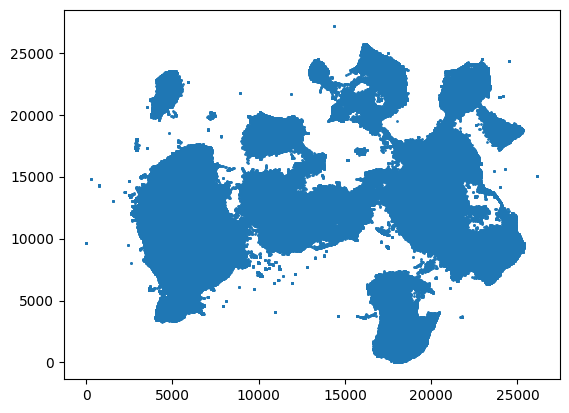

In [37]:
plt.scatter(embedding[:, 0], embedding[:, 1], s=1)
test['UMAP_X'] = embedding[:, 0]
test['UMAP_Y'] = embedding[:, 1]

In [44]:
test[test['CellID'] == 98]

,CellID,Hoechst0,Hoechst1,Hoechst2,anti_CD3,anti_CD45RO,Hoechst3,Keratin_570,aSMA_660,Hoechst4,...,Orientation,Sample,Condition,Replicate,emb1,emb2,cluster_2d,UMAP_X,UMAP_Y,kmeans
31,98,20302.555556,40707.611111,29824.666667,0.34083,0.670913,13175.972222,0.387867,0.209172,16273.277778,...,1.439512,WD-76845-097,CRC,1,8.259693,20.344513,48,15698.37666,21316.855316,4


In [45]:
test.to_csv('/Users/swarchol/Research/bed/data/for_simon_with_umap.csv', index=False)
test.to_parquet('/Users/swarchol/Research/bed/data/for_simon_with_umap.parquet', index=False)

In [46]:
test[['X_centroid']]

,X_centroid
0,9421.436364
1,9460.328125
2,9475.702703
3,9507.795455
4,9513.478261
...,...
933248,7316.808511
933249,7084.936508
933250,6961.650794
933251,6942.491803


In [19]:
cell_id_set = set(cluster_df['CellID'])
cell_id_set

{47,
 49,
 51,
 52,
 53,
 55,
 56,
 57,
 62,
 63,
 64,
 66,
 68,
 70,
 71,
 73,
 75,
 76,
 77,
 78,
 81,
 83,
 84,
 88,
 89,
 91,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 101,
 102,
 106,
 107,
 108,
 112,
 113,
 114,
 115,
 117,
 118,
 119,
 120,
 121,
 122,
 124,
 125,
 126,
 128,
 129,
 131,
 134,
 135,
 138,
 139,
 140,
 141,
 145,
 146,
 147,
 149,
 151,
 152,
 153,
 154,
 155,
 157,
 159,
 163,
 165,
 166,
 167,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 179,
 182,
 184,
 185,
 187,
 189,
 190,
 193,
 194,
 195,
 196,
 198,
 199,
 200,
 201,
 202,
 203,
 205,
 206,
 209,
 210,
 211,
 212,
 216,
 219,
 224,
 225,
 226,
 227,
 232,
 233,
 239,
 240,
 241,
 242,
 245,
 246,
 249,
 251,
 252,
 256,
 258,
 259,
 260,
 261,
 262,
 263,
 264,
 265,
 267,
 268,
 269,
 270,
 271,
 272,
 274,
 275,
 277,
 279,
 280,
 286,
 288,
 289,
 291,
 293,
 295,
 296,
 298,
 299,
 301,
 305,
 306,
 307,
 310,
 311,
 312,
 316,
 327,
 328,
 329,
 330,
 332,
 333,
 334,
 335,
 336,
 338,
 339,
 

In [15]:
tiled_io = tf.TiffFile('/Users/swarchol/Downloads/Ton_378_Cropped_Nuclei_Mask.tif',is_ome=True)
tiled_zarr = zarr.open(tiled_io.series[0].aszarr())
tiled_zarr


<tifffile.TiffFile 'Ton_378_Cropped_Nuclei_Mask.tif'> OME series contains index out of range, raised IndexError('index 1 out of range(1)')
<tifffile.TiffFile 'Ton_378_Cropped_Nuclei_Mask.tif'> OME series contains index out of range, raised IndexError('index 2 out of range(1)')
<tifffile.TiffFile 'Ton_378_Cropped_Nuclei_Mask.tif'> OME series contains index out of range, raised IndexError('index 3 out of range(1)')
<tifffile.TiffFile 'Ton_378_Cropped_Nuclei_Mask.tif'> OME series contains index out of range, raised IndexError('index 4 out of range(1)')
<tifffile.TiffFile 'Ton_378_Cropped_Nuclei_Mask.tif'> OME series contains index out of range, raised IndexError('index 5 out of range(1)')


<zarr.hierarchy.Group '/'>

In [18]:
tiled_io = tf.TiffFile('/Users/swarchol/Downloads/tiled-mask.ome.ome.tiff',is_ome=True)
tiled_zarr = zarr.open(tiled_io.series[0].aszarr())
tiled_zarr
tiled_zarr


<zarr.hierarchy.Group '/'>

In [25]:
tiled_zarr[5]

<zarr.core.Array '/5' (847, 816) uint32>

In [21]:
np_image_zarr = np.array(tiled_zarr[0])

In [22]:
np_image_zarr

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint32)

In [23]:

index_map = {}
for i in tqdm(range(np_image_zarr.shape[0])):
    for j in range(np_image_zarr.shape[1]):
        val = np_image_zarr[i,j]
        if val not in cell_id_set:
            continue
        else:
            if val not in index_map:
                index_map[val] = []
            index_map[val].append((i,j))
        

100%|██████████| 27120/27120 [01:39<00:00, 271.87it/s]


In [28]:
len(index_map)

29060

In [26]:
cluster_df['UMAP_X'] = -1
cluster_df['UMAP_Y'] = -1
for key in tqdm(index_map.keys()):
    indices = index_map[key]
    x = np.mean([i[0] for i in indices])
    y = np.mean([i[1] for i in indices])
    cluster_df.loc[cluster_df['CellID'] == key, 'UMAP_X'] = x
    cluster_df.loc[cluster_df['CellID'] == key, 'UMAP_Y'] = y

  0%|          | 0/29060 [00:00<?, ?it/s]/var/folders/ps/x7v31pds3gn4t11djwg0t03h0000gp/T/ipykernel_3682/582427471.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '37.338235294117645' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  cluster_df.loc[cluster_df['CellID'] == key, 'UMAP_X'] = x
/var/folders/ps/x7v31pds3gn4t11djwg0t03h0000gp/T/ipykernel_3682/582427471.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '17917.191176470587' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  cluster_df.loc[cluster_df['CellID'] == key, 'UMAP_Y'] = y
100%|██████████| 29060/29060 [00:33<00:00, 856.89it/s]


In [29]:
cluster_columns = ['Hoechst0', 'Hoechst1', 'Hoechst2', 'anti_CD3', 'anti_CD45RO',
       'Hoechst3', 'Keratin_570', 'aSMA_660', 'Hoechst4', 'CD4_488', 'CD45_PE',
       'PD1_647', 'Hoechst5', 'CD20_488', 'CD68_555', 'CD8a_660', 'Hoechst6',
       'CD163_488', 'FOXP3_570', 'PDL1_647', 'Hoechst7', 'Ecad_488',
       'Vimentin_555', 'CDX2_647', 'Hoechst8', 'LaminABC_488', 'Desmin_555',
       'CD31_647', 'Hoechst9', 'PCNA_488', 'CollagenIV_647',]

# K Mean cluster the data into 10 clusters
kmeans = KMeans(n_clusters=10, random_state=0).fit(cluster_df[cluster_columns])

In [31]:
cluster_df['kmeans'] = kmeans.labels_

In [32]:
# Save the data
cluster_df.to_parquet('/Users/swarchol/Research/bed/data/for_simon_with_umap.parquet')

In [51]:
test.to_csv('/Users/swarchol/Research/bed/data/for_simon_with_umap_lean.csv', index=False)

In [53]:
test_locations_and_clusters = test[['CellID', 'UMAP_X', 'UMAP_Y', 'kmeans', 'cluster_2d','X_centroid', 'Y_centroid']]
test_locations_and_clusters.to_csv('/Users/swarchol/Research/bed/data/for_simon_with_umap_locations.csv', index=False)